In [69]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve,recall_score, confusion_matrix, accuracy_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score
# import xgboost as xgb
import json
import pickle
import csv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import warnings
warnings.simplefilter('ignore')

# ライブラリ

In [18]:
import sys
sys.path.append('../')
from setting import *

# 入出力

In [102]:
# file_pred = data_path/'tmp/202012061919_all.csv'
file_f = 'bt_features.csv'
file_input_score = 'wh_score_all.csv'

In [5]:
df_f = pd.read_csv(file_f)
print(df_f.shape)
df_f.head(2)

(10469, 13)


,race_id,odds,acc_flg,score1,score2,s_diff,EV,EV_diff,s_diff_rate,weather_int_2,weather_int_3,condition_int_2,condition_int_3
0,201201010101,5.9,0,0.366473,0.329453,0.037019,2.162189,0.080043,0.013567,0,0,0,0
1,201201010104,3.7,1,0.483205,0.399544,0.083661,1.787858,0.149574,0.040425,0,0,0,0


# 読み込み

In [131]:
file_race_master = '../../../resource/common/race_info_master.csv'
df_info = pd.read_csv(
    file_race_master,
    usecols=['condition_int', 'weather_int', 'race_id']
).set_index('race_id')
print(df_info.shape)
df_info.head(2)

(27125, 2)


,condition_int,weather_int
race_id,,
201001020110,1,2
201001020111,1,2


In [132]:
file_race_transaction = '../../../resource/common/race_result_transaction.csv'
df_result = pd.read_csv(file_race_transaction, usecols=['race_id', '馬名', 'odds', 'horse_id'])
print(df_result.shape)
df_result.head(2)

(387828, 4)


,馬名,odds,race_id,horse_id
0,マイネルギブソン,6.0,201001020110,46108
1,ロビンフット,2.7,201001020110,46109


In [133]:
df_pred = pd.read_csv(file_pred, engine='python', encoding='cp932')
df_pred.head(2)

,arrival,horse_id,race_id,pred_prob
0,9,59994,201201010101,0.064628
1,3,59988,201201010101,0.329453


In [134]:
df_pred = df_pred.merge(df_result, how='left', on=['race_id', 'horse_id'])
print(df_pred.shape)
df_pred.head(2)

(148567, 6)


,arrival,horse_id,race_id,pred_prob,馬名,odds
0,9,59994,201201010101,0.064628,スリースペシャル,49.5
1,3,59988,201201010101,0.329453,マイネルゴスホーク,7.6


In [111]:
def get_pred(file_input_score):
    ## 読み込み
    df_pred = pd.read_csv(
        file_input_score,
        usecols=['race_id', 'horse_id', 'pred_prob'],
        # encoding='cp932'
    )
    df_pred['pred_rank'] = df_pred.groupby('race_id').pred_prob.rank(ascending=False, method='min')
    return df_pred

def make_cols(df_ac):
    df_ac['EV'] = df_ac.odds * df_ac.score1
    df_ac['EV_diff'] = df_ac.EV * df_ac.s_diff
    df_ac['s_diff_rate'] = df_ac.s_diff * df_ac.score1
    return df_ac

def get_info_cols(df_ac, file_input_info):
    df_info = pd.read_csv(
        file_input_info, 
        usecols=['condition_int', 'weather_int', 'race_id']
    )

    df_ac = df_ac.merge(df_info, how="left", on=['race_id'])
    df_use = pd.get_dummies(df_ac, columns=['weather_int', 'condition_int'], drop_first=True)
    return df_use


def get_odds(df_pred):
    num = len(df_pred)
    # df_master = pd.read_csv(file_horse_master, usecols=['horse_id', '馬名'])
    # df_pred = df_pred.merge(df_master, how='left', on='horse_id')
    df_transaction = pd.read_csv(file_race_transaction, usecols=['race_id', '馬名', 'odds', 'arrival', 'horse_id'])
    df_pred = df_pred.merge(df_transaction, how='left', on=['race_id', 'horse_id'])
#     print(df_pred.head(10))
    assert num == len(df_pred)
    return df_pred


In [130]:
# file_input_score = resource_path /f'model_build/logs/wh/202012130029/wh_score_all.csv'
df_pred_tmp = get_pred(file_input_score)
print(df_pred_tmp.shape)
df_pred_tmp = get_odds(df_pred_tmp)
df_ac_tmp = make_df_ac(df_pred_tmp)
df_ac_tmp = add_acc_flg(df_pred_tmp, df_ac_tmp) # 
df_ac_tmp = agg_all(df_pred_tmp, df_ac_tmp)
df_ac_tmp = make_cols(df_ac_tmp)
df_ac_tmp = get_info_cols(df_ac_tmp, file_race_master)
# df_ac_tmp.to_csv(resource_path /f'model_build/logs/wh/202012130029/bt_features.csv', index=False)

(148567, 4)


In [129]:
df_ac_tmp

,race_id,odds,acc_flg,score1,score2,s_diff,EV,EV_diff,s_diff_rate,weather_int_2,weather_int_3,condition_int_2,condition_int_3
0,201201010101,5.9,0,0.366473,0.329453,0.037019,2.162189,0.080043,0.013567,0,0,0,0
1,201201010104,3.7,1,0.483205,0.399544,0.083661,1.787858,0.149574,0.040425,0,0,0,0
2,201201010108,2.7,0,0.495654,0.350361,0.145293,1.338265,0.194440,0.072015,0,0,0,0
3,201201010110,3.7,0,0.309313,0.268529,0.040784,1.144460,0.046676,0.012615,0,0,0,0
4,201201010112,2.2,0,0.503848,0.285949,0.217899,1.108466,0.241534,0.109788,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10464,201910021206,1.8,0,0.557048,0.427142,0.129906,1.002687,0.130255,0.072364,0,1,0,1
10465,201910021208,8.1,0,0.395746,0.331567,0.064178,3.205542,0.205727,0.025398,0,1,0,1
10466,201910021209,4.2,0,0.386423,0.373529,0.012894,1.622976,0.020926,0.004982,0,1,0,1
10467,201910021211,4.5,0,0.442891,0.435563,0.007329,1.993012,0.014607,0.003246,1,0,0,1


In [124]:
df_ac

,odds,acc_flg,score1,score2,s_diff,condition_int,weather_int,EV,EV_diff,s_diff_rate
race_id,,,,,,,,,,
201201010101,1.7,0,0.366473,0.329453,0.037019,1,1,0.623004,0.023063,0.013567
201201010104,3.7,1,0.483205,0.399544,0.083661,1,1,1.787858,0.149574,0.040425
201201010108,4.9,0,0.495654,0.350361,0.145293,1,1,2.428703,0.352873,0.072015
201201010110,65.5,0,0.309313,0.268529,0.040784,1,1,20.260033,0.826290,0.012615
201201010112,28.5,0,0.503848,0.285949,0.217899,1,1,14.359675,3.128957,0.109788
...,...,...,...,...,...,...,...,...,...,...
201910021206,213.0,0,0.557048,0.427142,0.129906,3,3,118.651318,15.413564,0.072364
201910021208,14.0,0,0.395746,0.331567,0.064178,3,3,5.540443,0.355577,0.025398
201910021209,11.1,0,0.386423,0.373529,0.012894,3,3,4.289293,0.055305,0.004982


# 正解フラグ

In [ ]:
df_pred['pred_rank'] = df_pred.groupby('race_id').pred_prob.rank(ascending=False, method='min')


In [135]:
df_pred['pred_rank'] = df_pred.groupby('race_id').pred_prob.rank(ascending=False, method='min')

In [ ]:
def make_df_ac(df_pred):
    df_ac = pd.DataFrame(index=df_pred.race_id.unique())
    df_ac.index.name = 'race_id'
    df_ac = df_ac.reset_index().merge(
        df_pred.query('pred_rank==1')[['race_id', 'odds']].drop_duplicates('race_id'),
        how='left',
        on='race_id'
    )
    return df_ac

In [ ]:
def get_pivot(df_pred):
    tmp = pd.pivot_table(
        df_pred.query('pred_rank <=2'),
        values='pred_prob',
        index='race_id',
        columns='pred_rank'
    )
    tmp.columns = ['score1', 'score2']
    tmp['s_diff'] = tmp.score1 - tmp.score2
    return tmp.reset_index()

In [ ]:
def agg_all(df_pred, df_ac):
    df_pivot = get_pivot(df_pred)
    df_ac = df_ac.merge(df_pivot, how='left', on='race_id')
    return df_ac

In [ ]:
def add_acc_flg(df_pred, df_ac):
    ## 正解フラグ
    accuracy_id = df_pred.query('(arrival==1) and (pred_rank==1)').race_id
    df_ac['acc_flg'] = 0
    df_ac.loc[df_ac.race_id.isin(accuracy_id), 'acc_flg'] = 1
    return df_ac

In [146]:
df_ac = pd.DataFrame(index=df_pred.race_id.unique())
df_ac.index.name = 'race_id'

In [150]:
tmp1 = df_ac.reset_index()

In [151]:
tmp2 = df_ac.copy()

In [158]:
tmp1.merge(
    df_pred.query('pred_rank==1')[['race_id', 'odds']].drop_duplicates('race_id'),
    how='left',
    on='race_id'
)

,race_id,odds
0,201201010101,5.9
1,201201010104,3.7
2,201201010108,2.7
3,201201010110,3.7
4,201201010112,2.2
...,...,...
10464,201910021206,1.8
10465,201910021208,8.1
10466,201910021209,4.2
10467,201910021211,4.5


In [157]:
tmp2.merge(
    df_pred.query('pred_rank==1')[['race_id', 'odds']].drop_duplicates('race_id').set_index('race_id'),
    how='left',
    left_index=True,
    right_index=True
)

,odds
race_id,
201201010101,5.9
201201010104,3.7
201201010108,2.7
201201010110,3.7
201201010112,2.2
...,...
201910021206,1.8
201910021208,8.1
201910021209,4.2


In [142]:
accuracy_id = df_pred.query('(arrival==1) and (pred_rank==1)').race_id

df_ac = df_ac.reset_index().merge(
    df_pred.query('pred_rank==1')[['race_id', 'odds']].drop_duplicates('race_id'),
    how='left',
    on='race_id'
)
df_ac

,race_id,odds
0,201201010101,5.9
1,201201010104,3.7
2,201201010108,2.7
3,201201010110,3.7
4,201201010112,2.2
...,...,...
10464,201910021206,1.8
10465,201910021208,8.1
10466,201910021209,4.2
10467,201910021211,4.5


In [165]:
aaa = df_pred.query('arrival==1')[['race_id', 'odds']]
aaa.loc[aaa.duplicated('race_id', keep=False)].sort_values('race_id')

,race_id,odds
3099,201204020212,3.6
3108,201204020212,2.9
8104,201207030411,4.1
8106,201207030411,24.0
32505,201401020311,5.1
32512,201401020311,15.6
56283,201504020709,2.9
56293,201504020709,5.7
60235,201505050909,5.1
60239,201505050909,2.8


In [194]:
df_pred['odds_rank'] = df_pred.groupby('race_id').odds.rank(ascending=True, method='min')

In [195]:
df_ac = pd.DataFrame(index=df_pred.race_id.unique())
df_ac.index.name = 'race_id'
# df_ac = df_ac.merge(
#     df_pred.query('odds_rank==1')[['race_id', 'odds']].drop_duplicates('race_id').set_index('race_id'),
#     how='left',
#     left_index=True,
#     right_index=True
# )

In [197]:
df_ac['acc_flg'] = 0
df_ac.loc[df_ac.index.isin(accuracy_id), 'acc_flg'] = 1
tmp = pd.pivot_table(
    df_pred.query('pred_rank <=2'),
    values='pred_prob',
    index='race_id',
    columns='pred_rank'
)
tmp.columns = ['score1', 'score2']
df_ac = df_ac.merge(tmp, how='left', left_index=True, right_index=True)
df_ac['s_diff'] = df_ac.score1 - df_ac.score2

df_ac = df_ac.merge(df_info, how='left', left_index=True, right_index=True)

df_ac['EV'] = df_ac.odds * df_ac.score1
df_ac['EV_diff'] = df_ac.EV * df_ac.s_diff
df_ac['s_diff_rate'] = df_ac.s_diff * df_ac.score1

In [198]:
df_ac.head()

,odds,acc_flg,score1,score2,s_diff,condition_int,weather_int,EV,EV_diff,s_diff_rate
race_id,,,,,,,,,,
201201010101,1.7,0,0.366473,0.329453,0.037019,1,1,0.623004,0.023063,0.013567
201201010104,2.7,1,0.483205,0.399544,0.083661,1,1,1.304653,0.109149,0.040425
201201010108,2.7,0,0.495654,0.350361,0.145293,1,1,1.338265,0.194440,0.072015
201201010110,2.4,0,0.309313,0.268529,0.040784,1,1,0.742352,0.030276,0.012615
201201010112,2.2,0,0.503848,0.285949,0.217899,1,1,1.108466,0.241534,0.109788


# 購入閾値検索

In [123]:
def get_return(df, col, vmax=1, step=0.01, over=True, plot_min=0.8):
    df_ret = pd.DataFrame(columns=['対象数', '回収率'])
    if over:
        op = '>'
    else:
        op = '<'
    max_ret = -10000
    max_th = -1
    max_len = -1
    for th in np.arange(0, vmax, step):
        th = round(th, 2)
        tmp = df.query(col + op + str(th))
        ret = round((tmp.query('acc_flg==1').odds.sum()/tmp.shape[0]), 3)
        if ret > max_ret:
            max_ret = ret
            max_th = th
            max_len = len(tmp)
        df_ret.loc[th] = [tmp.shape[0], ret]
    print(f'対象カラム: {col}, 最大回収率: {max_ret}, 閾値: {max_th}, 対象数: {max_len}, 対象率: {round(max_len/df.shape[0], 3)}')
    
    df_ret['対象率'] = df_ret.対象数 / df.shape[0]
    
#     plt.scatter(max_th, max_ret, s=100, c='none', edgecolors='blue')
    df_ret.回収率.plot()
    plt.plot([0,vmax], [1,1])
    plt.ylim(plot_min, )
    plt.ylabel('回収率')
    plt.xlabel(col)
    plt.twinx()
    df[col].hist(bins=20, alpha=.1, color='c', grid=False, range=(0, vmax))
    plt.ylabel('件数')
    plt.show()
    return df_ret, max_th

# 購入モデル

## ライブラリ

In [71]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve,recall_score, confusion_matrix, accuracy_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score

## 学習データ作成

In [199]:
# one-hot
df_use = pd.get_dummies(df_ac, columns=['weather_int', 'condition_int'], drop_first=True).dropna()

# target
df_use['target'] = df_use.acc_flg.copy()

In [200]:
df_train, df_test = train_test_split(df_use)
print(df_train.shape)
print(df_test.shape)

(7851, 13)
(2617, 13)


In [201]:
# 不均衡データ調整
target_size = (df_train.target==1).sum()

df_train_0 = df_train[df_train.target==0]
df_train_use = df_train_0.sample(target_size, random_state=0)
df_train_use = pd.concat([df_train_use, df_train[df_train.target==1]])

# X_train_use = X_train.loc[y_train_use.index]

In [202]:
X_cols = [col for col in df_train.columns if col not in {'acc_flg', 'target', 'race_id'}]
print(len(X_cols))

11


In [203]:
X_train = df_train_use[X_cols]
X_test = df_test[X_cols]
y_train = df_train_use['target']
y_test = df_test['target']

# X_train = df_use[X_cols]
# y_train = df_use['target']
# X_test = df_use[X_cols]
# y_test = df_use['target']

In [204]:
tmp = y_train.to_frame()
tmp['種類'] = 'train'
tmp2 = y_test.to_frame()
tmp2['種類'] = 'test'
tmp3 = pd.concat([tmp, tmp2])
df_sampling = pd.crosstab(tmp3.種類, tmp3.target, margins=True)
df_sampling

target,0,1,All
種類,,,
test,1954,663,2617
train,1833,1833,3666
All,3787,2496,6283


In [205]:
s_rate = y_test.sum() / len(y_test)
# s_rate = (y_test==1).sum() / y_test.shape[0]
s_rate

0.2533435231180741

## 学習

In [206]:
clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [207]:
pd.Series(clf.coef_[0], X_train.columns).to_frame()

,0
odds,-0.433609
score1,1.587320
score2,0.504533
s_diff,1.082787
EV,0.082186
EV_diff,-0.332268
s_diff_rate,0.754444
weather_int_2,0.090856
weather_int_3,0.345280
condition_int_2,-0.115885


## 予測

In [208]:
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:, 1]

In [209]:
prob2 = y_pred_prob / (y_pred_prob + (1 - y_pred_prob) / s_rate)

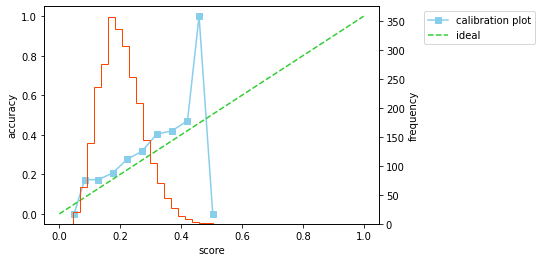

In [210]:
prob_true, prob_pred = calibration_curve(y_true=y_test, y_prob=prob2, n_bins=20)

fig, ax1 = plt.subplots()
ax1.plot(prob_pred, prob_true, marker='s', label='calibration plot', color='skyblue')
ax1.plot([0, 1], [0, 1], linestyle='--', label='ideal', color='limegreen')
ax1.legend(bbox_to_anchor=(1.12, 1), loc='upper left')
ax2 = ax1.twinx()
ax2.hist(prob2, bins=20, histtype='step', color='orangered')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('score')
ax2.set_ylabel('frequency')
# fig.savefig(log_path/'image/calibration_plot.png', bbox_inches='tight', pad_inche=.05)
plt.show()

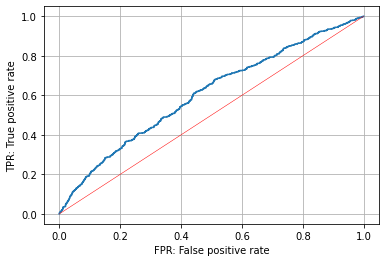

In [211]:
fpr_all, tpr_all, thresholds_all = roc_curve(y_test, y_pred_prob, drop_intermediate=False)
fig, ax = plt.subplots()
ax.plot(fpr_all, tpr_all, marker='o', markersize=.01)
ax.plot([0,1],[0,1], color='red', linewidth=.5)
ax.set_xlabel('FPR: False positive rate')
ax.set_ylabel('TPR: True positive rate')
ax.grid()
# fig.savefig(log_path/'image/roc_plot.png', bbox_inches='tight', pad_inche=.05)

In [212]:
roc_auc_score(y_test, y_pred_prob)

0.6040700824853995

## 閾値検索

In [213]:
df_test['pred'] = prob2

対象カラム: pred, 最大回収率: 1.057, 閾値: 0.43, 対象数: 7, 対象率: 0.003


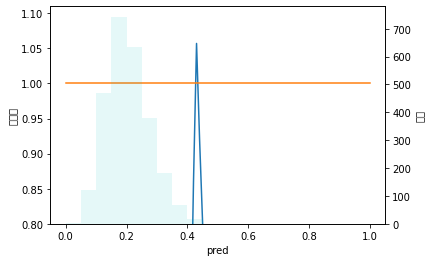

In [214]:
df_ret, max_th = get_return(df_test, 'pred', 1, 0.01, over=True, plot_min=0.8)

In [215]:
df_ret.head()

,対象数,回収率,対象率
0.00,2617.0,0.635,1.0
0.01,2617.0,0.635,1.0
0.02,2617.0,0.635,1.0
0.03,2617.0,0.635,1.0
0.04,2617.0,0.635,1.0


In [216]:
df_ret.loc[0.2: 0.5]

,対象数,回収率,対象率
0.20,1282.0,0.647,0.489874
0.21,1143.0,0.623,0.436760
0.22,1010.0,0.616,0.385938
0.23,874.0,0.618,0.333970
0.24,759.0,0.638,0.290027
0.25,648.0,0.639,0.247612
0.26,543.0,0.636,0.207489
0.27,459.0,0.661,0.175392
0.28,388.0,0.666,0.148261
0.29,313.0,0.666,0.119603


In [217]:
df_test['buy'] = 0
df_test.loc[df_test.pred > 0.4, 'buy'] = 1

buy
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: EV, dtype: object

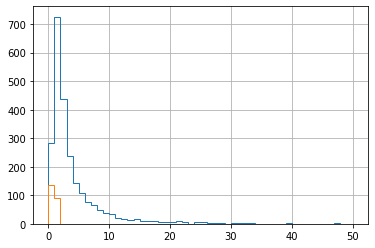

In [99]:
df_test.groupby('buy').EV.hist(bins=50, range=(0, 50), histtype='step')